In [3]:
pip install opencv-python-headless dlib imagehash numpy pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.6 MB/s eta 0:00:00


In [4]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 48.0 MB/s eta 0:00:00


In [5]:
!pip install ImageHash

IMPORTING LIBRARIES

In [6]:
import cv2  # OpenCV library for computer vision tasks, such as image and video processing
import os  # Provides functions to interact with the operating system, such as file and directory manipulation
import mediapipe as mp  # MediaPipe library for machine learning solutions for face, hand, and body tracking
import dlib  # Dlib library for machine learning and computer vision, commonly used for face detection and shape prediction
import pandas as pd  # Pandas library for data manipulation and analysis
import matplotlib.pyplot as plt  # Matplotlib library for creating static, interactive, and animated visualizations
import seaborn as sns  # Seaborn library for statistical data visualization, built on top of Matplotlib
import numpy as np  # NumPy library for numerical computations and array manipulations
import imagehash  # ImageHash library for perceptual hashing of images to find similarities or detect changes
from PIL import Image  # Python Imaging Library (PIL) for image processing, now maintained under the Pillow package

# Importing additional libraries for advanced signal processing
from scipy.signal import savgol_filter, find_peaks  # SciPy functions for signal smoothing (Savitzky-Golay filter) and pe

FACE DETECTION FOR INHOUSE DATASET

In [9]:
def create_directories(base_dir):
    """
    Creates directories for storing all frames and detected frames.

    Parameters:
        base_dir (str): Base directory to create subdirectories.

    Returns:
        tuple: Paths to the all_frames and detected_frames directories.
    """
    print("creating directories")
    all_frames_dir = os.path.join(base_dir, "all_frames")
    os.makedirs(all_frames_dir, exist_ok=True)
    detected_dir = os.path.join(base_dir, "detected_frames")
    os.makedirs(detected_dir, exist_ok=True)
    return all_frames_dir, detected_dir

def haar_cascade_detection(video_path, output_dir):
    """
    Performs face detection using Haar Cascade.

    Parameters:
        video_path (str): Path to the input video.
        output_dir (str): Directory to save the output frames.

    Returns:
        tuple: Detected bounding boxes, true positives (TP), and false negatives (FN).
    """
    print("For Harr Cascade")
    bounding_boxes_haar = []
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    output_dir, detected_dir = create_directories(output_dir)

    cap = cv2.VideoCapture(video_path)
    TP = FN = 0
    ground_truth = {i: True for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))}

    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

        detected = len(faces) > 0
        if ground_truth.get(frame_idx, False):
            TP += detected
            FN += not detected

        if detected:
            for (x, y, w, h) in faces:
                bounding_boxes_haar.append((frame_idx, x, y, w, h))
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.imwrite(os.path.join(detected_dir, f"frame_{frame_idx:04d}.jpg"), frame)

        cv2.imwrite(os.path.join(output_dir, f"frame_{frame_idx:04d}.jpg"), frame)
        frame_idx += 1

    cap.release()
    return bounding_boxes_haar,TP, FN

def mediapipe_detection(video_path, output_dir):
    """
    Performs face detection using MediaPipe.

    Parameters:
        video_path (str): Path to the input video.
        output_dir (str): Directory to save the output frames.

    Returns:
        tuple: Detected bounding boxes, true positives (TP), and false negatives (FN).
    """
    print("For Mediapipe")
    bounding_boxes_mediapipe = []
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
    output_dir, detected_dir = create_directories(output_dir)

    cap = cv2.VideoCapture(video_path)
    TP = FN = 0
    ground_truth = {i: True for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))}

    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        detected = results.detections is not None
        if ground_truth.get(frame_idx, False):
            TP += detected
            FN += not detected

        if detected:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = frame.shape
                x, y, box_w, box_h = (int(bboxC.xmin * w), int(bboxC.ymin * h),
                                      int(bboxC.width * w), int(bboxC.height * h))
                bounding_boxes_mediapipe.append((frame_idx, x, y, box_w, box_h))
                cv2.rectangle(frame, (x, y), (x + box_w, y + box_h), (255, 0, 0), 2)

            cv2.imwrite(os.path.join(detected_dir, f"frame_{frame_idx:04d}.jpg"), frame)

        cv2.imwrite(os.path.join(output_dir, f"frame_{frame_idx:04d}.jpg"), frame)
        frame_idx += 1

    cap.release()
    return bounding_boxes_mediapipe, TP, FN

def dlib_detection(video_path, output_dir):
    """
    Performs face detection using Dlib.

    Parameters:
        video_path (str): Path to the input video.
        output_dir (str): Directory to save the output frames.

    Returns:
        tuple: Detected bounding boxes, true positives (TP), and false negatives (FN).
    """
    print("For Dlib")
    bounding_boxes_dlib = []
    detector = dlib.get_frontal_face_detector()
    output_dir, detected_dir = create_directories(output_dir)

    cap = cv2.VideoCapture(video_path)
    TP = FN = 0
    ground_truth = {i: True for i in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))}

    frame_idx = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray)

        detected = len(faces) > 0
        if ground_truth.get(frame_idx, False):
            TP += detected
            FN += not detected

        if detected:
            for face in faces:
                x, y, w, h = face.left(), face.top(), face.width(), face.height()
                bounding_boxes_dlib.append((frame_idx, x, y, w, h))
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.imwrite(os.path.join(detected_dir, f"frame_{frame_idx:04d}.jpg"), frame)

        cv2.imwrite(os.path.join(output_dir, f"frame_{frame_idx:04d}.jpg"), frame)
        frame_idx += 1

    cap.release()
    return bounding_boxes_dlib, TP, FN

def calculate_accuracy(TP, FN):
    """
    Calculates accuracy based on true positives and false negatives.

    Parameters:
        TP (int): True Positives count.
        FN (int): False Negatives count.

    Returns:
        float: Accuracy percentage.
    """
    return TP / (TP + FN) * 100 if (TP + FN) > 0 else 0

def main(video_path, method, output_dir):

    """
    Main function to perform face detection using specified method.

    Parameters:
        video_path (str): Path to the input video.
        method (str): Face detection method ('haar', 'mediapipe', 'dlib').
        output_dir (str): Directory to save the output frames.

    Returns:
        list: Bounding box coordinates for detected faces.
    """
    bounding_boxes_coordinates = []
    if method == 'haar':
       bounding_boxes_coordinates,TP, FN = haar_cascade_detection(video_path, output_dir)
    elif method == 'mediapipe':
        bounding_boxes_coordinates,TP, FN = mediapipe_detection(video_path, output_dir)
    elif method == 'dlib':
        bounding_boxes_coordinates,TP, FN = dlib_detection(video_path, output_dir)
    else:
        print("Invalid method. Choose 'haar', 'mediapipe', or 'dlib'.")
        return

    accuracy = calculate_accuracy(TP, FN)
    print(f"{method.capitalize()} Accuracy: {accuracy:.2f}%")
    print(f"Bounding Box Coordinates ({method.capitalize()}):")
    if method == 'haar':
        print(bounding_boxes_coordinates)
        return bounding_boxes_coordinates
    elif method == 'mediapipe':
        print(bounding_boxes_coordinates)
        return bounding_boxes_coordinates
    elif method == 'dlib':
        print(bounding_boxes_coordinates)
        return bounding_boxes_coordinates

# Paths and method selection for running the face detection
video_path = "/content/Niharikatest.mp4"
method = "haar"  # Choose from 'haar', 'mediapipe', 'dlib'
output_dir = "/content/face_detection_haar"

method2="mediapipe"
output_dir2 = "/content/face_detection_mediapipe"

method3 = "dlib"
output_dir3 = "/content/face_detection_dlib"

calib_video="/content/Niharikacalibvideo.mp4"
output_dir_calib= "/content/face_detection_calib"


bounding_boxes_haar = main(video_path, method, output_dir)
bounding_boxes_mediapipe = main(video_path, method2, output_dir2)
bounding_boxes_dlib = main(video_path, method3, output_dir3)
bounding_boxes_caliberation = main(calib_video, method2, output_dir_calib)



For Harr Cascade
creating directories
Haar Accuracy: 80.50%
Bounding Box Coordinates (Haar):
[(0, 765, 417, 473, 473), (1, 767, 417, 471, 471), (2, 766, 415, 475, 475), (3, 768, 417, 472, 472), (4, 767, 417, 474, 474), (5, 767, 420, 471, 471), (6, 769, 420, 469, 469), (7, 766, 419, 476, 476), (8, 770, 422, 464, 464), (9, 770, 421, 468, 468), (10, 770, 420, 465, 465), (11, 768, 419, 467, 467), (12, 765, 417, 476, 476), (13, 771, 420, 468, 468), (14, 766, 418, 472, 472), (15, 767, 418, 471, 471), (16, 766, 417, 474, 474), (17, 767, 417, 473, 473), (18, 766, 416, 477, 477), (19, 766, 418, 474, 474), (20, 766, 416, 477, 477), (21, 765, 414, 480, 480), (22, 765, 416, 476, 476), (23, 764, 416, 475, 475), (24, 766, 418, 474, 474), (25, 766, 418, 476, 476), (26, 767, 419, 473, 473), (27, 766, 418, 474, 474), (28, 767, 420, 472, 472), (29, 771, 420, 469, 469), (30, 770, 420, 471, 471), (31, 771, 418, 470, 470), (32, 773, 420, 468, 468), (33, 774, 423, 463, 463), (34, 770, 421, 470, 470), (35, 7

EYE DETECTION FOR INHOUSE DATASET

In [10]:
# Helper function to check if directory exists
def check_directory_exists(directory):
    """
    Check if a directory exists.

    Parameters:
        directory (str): Path to the directory.

    Returns:
        bool: True if the directory exists, False otherwise.
    """
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist!")
        return False
    return True

# Haar Cascade Eye Detection
def haar_eye_detection(input_dir, output_dir):
    """
    Performs eye detection using Haar Cascade.

    Args:
        input_dir (str): Directory containing input frames.
        output_dir (str): Directory to save output frames.

    Returns:
        list: List of bounding boxes for detected eyes.
    """
    print("Running Haar Cascade Eye Detection...")

    # Load Haar Cascade classifiers for face and eye detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist

    haar_bounding_boxes = []  # List to store bounding box coordinates

    if not check_directory_exists(input_dir):
        return

    # Get a sorted list of frame files in the input directory
    frames = sorted([f for f in os.listdir(input_dir) if f.endswith('.jpg')])
    total_frames_with_faces = len(frames)
    correct_eye_detections = 0

    # Process each frame
    for i, frame_file in enumerate(frames):
        frame_path = os.path.join(input_dir, frame_file)
        frame = cv2.imread(frame_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)   # Convert frame to grayscale

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        eyes_detected = False

        for (x, y, w, h) in faces:
            # Get the region of interest (ROI) for the detected face
            roi_gray = gray[y:y + h, x:x + w]
            eyes = eye_cascade.detectMultiScale(roi_gray)   # Detect eyes in the face ROI
            if len(eyes) > 0:
                eyes_detected = True
                for (ex, ey, ew, eh) in eyes:
                    # Draw rectangle around detected eyes
                    cv2.rectangle(frame, (x + ex, y + ey), (x + ex + ew, y + ey + eh), (0, 255, 0), 2)
                    # Store bounding boxes in the global list
                    haar_bounding_boxes.append((i, x + ex, y + ey, ew, eh))  # Append bounding box

        if eyes_detected:
            correct_eye_detections += 1
            cv2.imwrite(os.path.join(output_dir, frame_file), frame)   # Save the frame with detections

     # Calculate and print accuracy
    accuracy = (correct_eye_detections / total_frames_with_faces) * 100 if total_frames_with_faces > 0 else 0
    print(f"Haar Cascade Accuracy: {accuracy:.2f}%")
    return haar_bounding_boxes

# Mediapipe Eye Detection
def mediapipe_eye_detection(input_dir, output_dir):
    """
    Performs eye detection using Mediapipe.

    Args:
        input_dir (str): Directory containing input frames.
        output_dir (str): Directory to save output frames.

    Returns:
        list: List of bounding boxes for detected eyes.
    """
    print("Running Mediapipe Eye Detection...")

    # Initialize Mediapipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)
    os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist

    mediapipe_bounding_boxes = []   # List to store bounding box coordinates


    if not check_directory_exists(input_dir):
        return

    # Get a sorted list of frame files in the input directory
    frames = sorted([f for f in os.listdir(input_dir) if f.endswith('.jpg')])
    total_frames_with_faces = len(frames)
    correct_eye_detections = 0

    # Process each frame
    for i, frame_file in enumerate(frames):
        frame_path = os.path.join(input_dir, frame_file)
        frame = cv2.imread(frame_path)
        results = face_mesh.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))   # Process frame using Mediapipe

        eyes_detected = False
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                h, w, _ = frame.shape

                # Extract left and right eye coordinates from landmarks
                left_eye_coords = [(int(pt.x * w), int(pt.y * h)) for pt in [
                    face_landmarks.landmark[33], face_landmarks.landmark[159],
                    face_landmarks.landmark[133], face_landmarks.landmark[145]
                ]]
                right_eye_coords = [(int(pt.x * w), int(pt.y * h)) for pt in [
                    face_landmarks.landmark[362], face_landmarks.landmark[386],
                    face_landmarks.landmark[263], face_landmarks.landmark[374]
                ]]

                if left_eye_coords and right_eye_coords:
                    eyes_detected = True
                    # Calculate bounding boxes for left and right eyes
                    left_eye_bbox = cv2.boundingRect(np.array(left_eye_coords))
                    right_eye_bbox = cv2.boundingRect(np.array(right_eye_coords))

                    # Store the bounding boxes along with frame number
                    mediapipe_bounding_boxes.append((frame_file, left_eye_bbox, right_eye_bbox))   # Append bounding boxes
                    for pt in left_eye_coords + right_eye_coords:
                        cv2.circle(frame, pt, 2, (0, 255, 0), -1)  # Draw circles at landmarks

        if eyes_detected:
            correct_eye_detections += 1
            cv2.imwrite(os.path.join(output_dir, frame_file), frame)  # Save the frame with detections

    # Calculate and print accuracy
    accuracy = (correct_eye_detections / total_frames_with_faces) * 100 if total_frames_with_faces > 0 else 0
    print(f"Mediapipe Accuracy: {accuracy:.2f}%")
    return mediapipe_bounding_boxes

# Dlib Eye Detection
def dlib_eye_detection(input_dir, output_dir):
    """
    Performs eye detection using Dlib.

    Args:
        input_dir (str): Directory containing input frames.
        output_dir (str): Directory to save output frames.

    Returns:
        list: List of bounding boxes for detected eyes.
    """

    print("Running Dlib Eye Detection...")

    # Initialize Dlib's face detector and shape predictor
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')  # Ensure you have this file in the directory
    os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist

    dlib_bounding_boxes =[]  # List to store bounding box coordinates

    if not check_directory_exists(input_dir):
        return

    # Get a sorted list of frame files in the input directory
    frames = sorted([f for f in os.listdir(input_dir) if f.endswith('.jpg')])
    total_frames_with_faces = len(frames)
    correct_eye_detections = 0

    # Process each frame
    for i, frame_file in enumerate(frames):
        frame_path = os.path.join(input_dir, frame_file)
        frame = cv2.imread(frame_path)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Convert frame to grayscale

        # Detect faces in the frame
        faces = detector(gray)
        eyes_detected = False

        for face in faces:
            landmarks = predictor(gray, face)   # Get facial landmarks
            # Extract coordinates for left and right eyes
            left_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)]
            right_eye = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)]

            if left_eye and right_eye:
                eyes_detected = True
                # Calculate bounding box for left and right eye
                min_x = min(left_eye + right_eye, key=lambda x: x[0])[0]
                min_y = min(left_eye + right_eye, key=lambda x: x[1])[1]
                max_x = max(left_eye + right_eye, key=lambda x: x[0])[0]
                max_y = max(left_eye + right_eye, key=lambda x: x[1])[1]
                eye_width = max_x - min_x
                eye_height = max_y - min_y
                # Store bounding box in the global list
                dlib_bounding_boxes.append((i, min_x, min_y, eye_width, eye_height))

                for pt in left_eye + right_eye:
                    cv2.circle(frame, pt, 2, (0, 255, 0), -1)

        if eyes_detected:
            correct_eye_detections += 1
            cv2.imwrite(os.path.join(output_dir, frame_file), frame)  # Save the frame with detections

    # Calculate and print accuracy
    accuracy = (correct_eye_detections / total_frames_with_faces) * 100 if total_frames_with_faces > 0 else 0
    print(f"Dlib Accuracy: {accuracy:.2f}%")
    return dlib_bounding_boxes

# Main Function
def main(input_dir,method, output_dir):
    print("Starting Eye Detection...")
    bounding_boxes_coordinates = []
    if method == 'haar':
        bounding_boxes_coordinates =  haar_eye_detection(input_dir, os.path.join(output_dir, "haar"))
        return bounding_boxes_coordinates
    elif method == 'mediapipe':
        bounding_boxes_coordinates = mediapipe_eye_detection(input_dir, os.path.join(output_dir, "mediapipe"))
        return bounding_boxes_coordinates
    elif method == 'dlib':
        bounding_boxes_coordinates = dlib_eye_detection(input_dir, os.path.join(output_dir, "dlib"))
        return bounding_boxes_coordinates
    else:
        print("Invalid method. Choose 'haar', 'mediapipe', or 'dlib'.")
        return


haar_input_dir = "/content/face_detection_haar/detected_frames"
mediapipe_input_dir = "/content/face_detection_mediapipe/detected_frames"
dlib_input_dir = "/content/face_detection_dlib/detected_frames"
calib_input_dir = "/content/face_detection_calib/detected_frames"

# Output base directory for all models
output_dir = "/content/eye_detection_frames"

# Paths and method selection for running eye detection
eye_haar_bounding_boxes = main(haar_input_dir,"haar",output_dir)

eye_mediapipe_bounding_boxes = main(mediapipe_input_dir,"mediapipe", output_dir)

eye_dlib_bounding_boxes = main(dlib_input_dir,"dlib", output_dir)

eye_calib_bounding_boxes = main(calib_input_dir,"mediapipe", output_dir)

# Print the bounding boxes for each model
print("Haar Bounding Boxes:", eye_haar_bounding_boxes)
print("Mediapipe Bounding Boxes:", eye_mediapipe_bounding_boxes)
print("Dlib Bounding Boxes:", eye_dlib_bounding_boxes)
print("Calibration Bounding Boxes:", eye_calib_bounding_boxes)


Starting Eye Detection...
Running Haar Cascade Eye Detection...
Haar Cascade Accuracy: 90.76%
Starting Eye Detection...
Running Mediapipe Eye Detection...
Mediapipe Accuracy: 99.34%
Starting Eye Detection...
Running Dlib Eye Detection...
Dlib Accuracy: 98.59%
Starting Eye Detection...
Running Mediapipe Eye Detection...
Mediapipe Accuracy: 100.00%
Haar Bounding Boxes: [(0, 1046, 540, 88, 88), (0, 840, 519, 132, 132), (0, 1006, 652, 44, 44), (0, 948, 644, 57, 57), (0, 906, 720, 76, 76), (1, 1047, 540, 88, 88), (1, 838, 517, 133, 133), (1, 949, 644, 57, 57), (1, 999, 644, 58, 58), (1, 906, 721, 76, 76), (2, 1044, 538, 91, 91), (2, 834, 513, 140, 140), (2, 1008, 655, 38, 38), (2, 949, 646, 54, 54), (2, 904, 720, 77, 77), (3, 1046, 540, 89, 89), (3, 837, 513, 141, 141), (3, 1004, 650, 47, 47), (3, 950, 645, 56, 56), (3, 906, 720, 76, 76), (4, 1045, 539, 90, 90), (4, 834, 511, 145, 145), (4, 1001, 649, 51, 51), (4, 948, 645, 57, 57), (4, 907, 721, 73, 73), (4, 979, 748, 82, 82), (5, 1045, 53

HELEN DATASET FACE DETECTION

In [11]:

# Initialize Mediapipe Face Detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Directory to save processed images with bounding boxes
output_dir = "/content/helen/Face_detection_helen"
os.makedirs(output_dir, exist_ok=True)

# Directory to save only face-detected images
detected_faces_dir = "/content/helen/Face_detected_helen"
os.makedirs(detected_faces_dir, exist_ok=True)

# Path to the directory containing images
image_dir = "/content/helendataset"  # Replace with the actual directory path of images

# Get all image file names from the directory
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Initialize the results list to store detection results
detection_results = []

# Process each image
for frame_idx, image_file in enumerate(image_files):
    # Read the image
    image_path = os.path.join(image_dir, image_file)
    frame = cv2.imread(image_path)

    if frame is None:
        print(f"Error reading image {image_file}. Skipping...")
        continue

    # Process the image for face detection
    results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Check if any faces were detected
    faces_detected = False
    if results.detections:
        faces_detected = True
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            h, w, _ = frame.shape
            x, y, box_w, box_h = (int(bboxC.xmin * w), int(bboxC.ymin * h),
                                  int(bboxC.width * w), int(bboxC.height * h))
            # Draw bounding box on the frame
            cv2.rectangle(frame, (x, y), (x + box_w, y + box_h), (255, 0, 0), 2)

        # Save face-detected images into the separate directory
        detected_face_path = os.path.join(detected_faces_dir, image_file)
        cv2.imwrite(detected_face_path, frame)

    # Save the processed image to the output folder
    output_path = os.path.join(output_dir, f"frame_{frame_idx:04d}.jpg")
    cv2.imwrite(output_path, frame)

    # Store the detection result (True if face is detected, False if not)
    detection_results.append((frame_idx, faces_detected))

# Output the detection results for each image
for frame_idx, detected in detection_results:
    print(f"Image {image_files[frame_idx]}: {'Face Detected' if detected else 'No Face Detected'}")

print(f"Processed images with face detection saved in '{output_dir}'")
print(f"Face-detected images saved in '{detected_faces_dir}'")

# Assuming every image contains a face
ground_truth = {
    frame_idx: True  # Face is present in every image
    for frame_idx in range(len(detection_results))
}

# Initialize counters for TP, FN
TP = FN = 0

# Compare predictions with ground truth
for frame_idx, detected in detection_results:
    if frame_idx in ground_truth:
        gt = ground_truth[frame_idx]
        if detected and gt:  # True Positive
            TP += 1
        elif not detected and gt:  # False Negative
            FN += 1

# Calculate accuracy
accuracy = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f"Accuracy: {accuracy * 100:.2f}%")


Image 2344972348_2.jpg: Face Detected
Image 147110327_1.jpg: Face Detected
Image 2075932440_1.jpg: Face Detected
Image 103236168_1.jpg: Face Detected
Image 24729177_1.jpg: Face Detected
Image 206283602_2.jpg: Face Detected
Image 2330954580_1.jpg: Face Detected
Image 1429860583_1.jpg: Face Detected
Image 2441861132_1.jpg: Face Detected
Image 2332408096_1.jpg: Face Detected
Image 106242334_1.jpg: Face Detected
Image 203328057_1.jpg: Face Detected
Image 1045890692_1.jpg: Face Detected
Image 2330955614_1.jpg: Face Detected
Image 232758871_1.jpg: Face Detected
Image 108349477_1.jpg: Face Detected
Image 105538305_1.jpg: No Face Detected
Image 2326107432_1.jpg: Face Detected
Image 107288942_1.jpg: Face Detected
Image 2330129413_1.jpg: Face Detected
Image 1434217156_1.jpg: Face Detected
Image 2326123678_2.jpg: Face Detected
Image 100040721_2.jpg: Face Detected
Image 2190903226_1.jpg: Face Detected
Image 2204494382_1.jpg: Face Detected
Image 2066420581_1.jpg: Face Detected
Image 1112052992_1.jp

HELEN DATASET EYE DETECTION

In [12]:

# Initialize Mediapipe Face Mesh for eye detection
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Directory containing face-detected images
face_detected_dir = "/content/helen/Face_detected_helen"

# Directory to save eye-detected images
eye_detected_dir = "/content/helen/Eye_detected_helen"
os.makedirs(eye_detected_dir, exist_ok=True)

# Get all image file names from the directory
image_files = [f for f in os.listdir(face_detected_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Initialize counters
ground_truth = len(image_files)  # Assuming eyes are labeled in every frame with a face detected
correct_eyes_detected = 0

# Process each image for eye detection
for image_file in image_files:
    # Read the image
    image_path = os.path.join(face_detected_dir, image_file)
    frame = cv2.imread(image_path)

    if frame is None:
        print(f"Error reading image {image_file}. Skipping...")
        continue

    # Convert the image to RGB for Mediapipe processing
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame for face mesh
    results = face_mesh.process(rgb_frame)

    # Check if eyes are detected
    eyes_detected = False
    if results.multi_face_landmarks:
        eyes_detected = True
        for face_landmarks in results.multi_face_landmarks:
            h, w, _ = frame.shape

            # Extract the left and right eye landmarks (Mediapipe indices)
            left_eye_landmarks = [
                face_landmarks.landmark[i] for i in [33, 133, 160, 159, 158, 144, 145, 153, 154, 155]
            ]
            right_eye_landmarks = [
                face_landmarks.landmark[i] for i in [362, 263, 387, 386, 385, 373, 374, 380, 381, 382]
            ]

            # Draw left eye landmarks
            for landmark in left_eye_landmarks:
                x, y = int(landmark.x * w), int(landmark.y * h)
                cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)

            # Draw right eye landmarks
            for landmark in right_eye_landmarks:
                x, y = int(landmark.x * w), int(landmark.y * h)
                cv2.circle(frame, (x, y), 2, (0, 255, 0), -1)

    # Save the processed image if eyes are detected
    output_path = os.path.join(eye_detected_dir, image_file)
    cv2.imwrite(output_path, frame)

    # Update the counter for correct eye detection
    if eyes_detected:
        correct_eyes_detected += 1

# Calculate eye detection accuracy
accuracy = correct_eyes_detected / ground_truth if ground_truth != 0 else 0
print(f"Accuracy of eye detection: {accuracy * 100:.2f}%")
print(f"Eye-detected images saved in '{eye_detected_dir}'")


Accuracy of eye detection: 100.00%
Eye-detected images saved in '/content/helen/Eye_detected_helen'


Blurring using Media pipe

In [13]:

# Function to process frames with blurred face and masked eyes
def process_frames(input_dir, output_dir, face_bounding_boxes, eye_bounding_boxes):
    os.makedirs(output_dir, exist_ok=True)

    for (frame_idx, face_x, face_y, face_w, face_h), (frame_name, left_eye_bbox, right_eye_bbox) in zip(face_bounding_boxes, eye_bounding_boxes):
        # Read the frame
        frame_path = os.path.join(input_dir, frame_name)
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Could not read frame {frame_path}")
            continue

        # Create a mask for the face area (white)
        mask = np.zeros_like(frame)  # Create a black mask of the same size as the frame
        cv2.rectangle(mask, (face_x, face_y), (face_x + face_w, face_y + face_h), (255, 255, 255), -1)  # Face mask in white

        # Subtract the eye regions (left and right eyes) from the mask (black)
        # Left Eye
        cv2.rectangle(mask, (left_eye_bbox[0], left_eye_bbox[1]),
                      (left_eye_bbox[0] + left_eye_bbox[2], left_eye_bbox[1] + left_eye_bbox[3]),
                      (0, 0, 0), -1)  # Remove left eye region by making it black

        # Right Eye
        cv2.rectangle(mask, (right_eye_bbox[0], right_eye_bbox[1]),
                      (right_eye_bbox[0] + right_eye_bbox[2], right_eye_bbox[1] + right_eye_bbox[3]),
                      (0, 0, 0), -1)  # Remove right eye region by making it black

        # Convert the mask to grayscale (only red channel for a 2D mask)
        mask = mask[:, :, 0]  # Use the red channel of the mask for a 2D mask

        # Apply Gaussian Blur to the entire face region (including eyes) but later mask the eyes out
        blurred_frame = cv2.GaussianBlur(frame, (251, 251), 0)

        # Combine the blurred frame with the original frame using the mask
        # First, copy the blurred version of the face area to the frame
        frame[mask == 255] = blurred_frame[mask == 255]

        # Save the processed frame
        output_path = os.path.join(output_dir, frame_name)
        cv2.imwrite(output_path, frame)

    print(f"Processed frames with blurred face (except eyes) saved in '{output_dir}'")

# Define input directories, bounding boxes, and output directories
input_dir_calib = "/content/face_detection_calib/detected_frames"
input_dir_test = "/content/face_detection_mediapipe/detected_frames"

output_dir_calib = "/content/Blur_Face_Eye_Detection_Calib"
output_dir_test = "/content/Blur_Face_Eye_Detection_Mediapipe"

# Replace these with your actual bounding box data
face_bounding_boxes_1 = bounding_boxes_caliberation
eye_bounding_boxes_1 = eye_calib_bounding_boxes

face_bounding_boxes_2 = bounding_boxes_mediapipe
eye_bounding_boxes_2 = eye_mediapipe_bounding_boxes

# Process frames for both datasets
process_frames(input_dir_calib, output_dir_calib, face_bounding_boxes_1, eye_bounding_boxes_1)
process_frames(input_dir_test, output_dir_test, face_bounding_boxes_2, eye_bounding_boxes_2)


Processed frames with blurred face (except eyes) saved in '/content/Blur_Face_Eye_Detection_Calib'
Processed frames with blurred face (except eyes) saved in '/content/Blur_Face_Eye_Detection_Mediapipe'


MASKING USING MEDIAPIPE

In [14]:

# Function to process frames with blurred face and masked eyes
def process_frames(input_dir, output_dir, face_bounding_boxes, eye_bounding_boxes):
    os.makedirs(output_dir, exist_ok=True)

    for (frame_idx, face_x, face_y, face_w, face_h), (frame_name, left_eye_bbox, right_eye_bbox) in zip(face_bounding_boxes, eye_bounding_boxes):
        # Read the frame
        frame_path = os.path.join(input_dir, frame_name)
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Warning: Could not read frame {frame_path}")
            continue

        # Create a mask for the face area (white)
        mask = np.zeros_like(frame)  # Create a black mask of the same size as the frame
        cv2.rectangle(mask, (face_x, face_y), (face_x + face_w, face_y + face_h), (255, 255, 255), -1)  # Face mask in white

        # Subtract the eye regions (left and right eyes) from the mask (black)
        # Left Eye
        cv2.rectangle(mask, (left_eye_bbox[0], left_eye_bbox[1]),
                      (left_eye_bbox[0] + left_eye_bbox[2], left_eye_bbox[1] + left_eye_bbox[3]),
                      (0, 0, 0), -1)  # Remove left eye region by making it black

        # Right Eye
        cv2.rectangle(mask, (right_eye_bbox[0], right_eye_bbox[1]),
                      (right_eye_bbox[0] + right_eye_bbox[2], right_eye_bbox[1] + right_eye_bbox[3]),
                      (0, 0, 0), -1)  # Remove right eye region by making it black

        # Convert the mask to grayscale (only red channel for a 2D mask)
        mask = mask[:, :, 0]  # Use the red channel of the mask for a 2D mask

        frame[mask == 255] = (255, 255, 255)  # Change the region corresponding to the mask to white (i.e., mask the face)



        # Save the processed frame
        output_path = os.path.join(output_dir, frame_name)
        cv2.imwrite(output_path, frame)

    print(f"Processed frames with Masked face (except eyes) saved in '{output_dir}'")

# Define input directories, bounding boxes, and output directories
input_dir_calib = "/content/face_detection_calib/detected_frames"
input_dir_test = "/content/face_detection_mediapipe/detected_frames"

output_dir_calib = "/content/Masked_Face_Eye_Detection_Calib"
output_dir_test = "/content/Masked_Face_Eye_Detection_Mediapipe"

# Replace these with your actual bounding box data
face_bounding_boxes_1 = bounding_boxes_caliberation
eye_bounding_boxes_1 = eye_calib_bounding_boxes

face_bounding_boxes_2 = bounding_boxes_mediapipe
eye_bounding_boxes_2 = eye_mediapipe_bounding_boxes

# Process frames for both datasets
process_frames(input_dir_calib, output_dir_calib, face_bounding_boxes_1, eye_bounding_boxes_1)
process_frames(input_dir_test, output_dir_test, face_bounding_boxes_2, eye_bounding_boxes_2)


Processed frames with Masked face (except eyes) saved in '/content/Masked_Face_Eye_Detection_Calib'
Processed frames with Masked face (except eyes) saved in '/content/Masked_Face_Eye_Detection_Mediapipe'


FINDING THRESHOLD FROM CALIBERATED VIDEO

In [15]:
# Function to calculate the difference hash (dhash)
def calculate_dhash(frame, hash_size=12):
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Resize the image to (hash_size + 1, hash_size)
    resized = cv2.resize(gray, (hash_size + 1, hash_size))
    # Create the difference hash by comparing adjacent pixels horizontally
    diff = resized[:, 1:] > resized[:, :-1]
    # Convert the binary difference to a hash
    dhash_value = imagehash.hex_to_hash("".join(['1' if b else '0' for b in diff.flatten()]))
    return dhash_value

# Function to calculate the threshold based on the maximum hash difference
def calculate_threshold(frame_paths, hash_size=12):
    hash_values = []
    # Calculate hash for each frame
    for frame_path in frame_paths:
        frame = cv2.imread(frame_path)

        # Check if the frame is loaded correctly
        if frame is None:
            print(f"Error: Unable to load image at {frame_path}")
            continue

        frame_hash = calculate_dhash(frame, hash_size)
        hash_values.append(frame_hash)

    # Calculate the differences between hashes
    max_diff = 0
    for i in range(len(hash_values)):
        for j in range(i + 1, len(hash_values)):
            diff = abs(hash_values[i] - hash_values[j])
            max_diff = max(max_diff, diff)

    return max_diff

# Example usage
folder_path = "/content/Masked_Face_Eye_Detection_Calib"  # Replace with actual frame paths
frame_paths = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        frame_paths.append(os.path.join(root, file))


# Verify that the frame paths are correct (optional)
for frame_path in frame_paths:
    if not os.path.exists(frame_path):
        print(f"Error: File {frame_path} does not exist!")

threshold_val = calculate_threshold(frame_paths, hash_size=12)

print(f"The calculated threshold value using dhash with size 12 is: {threshold_val}")


The calculated threshold value using dhash with size 12 is: 13


ANOMALY DETECTION

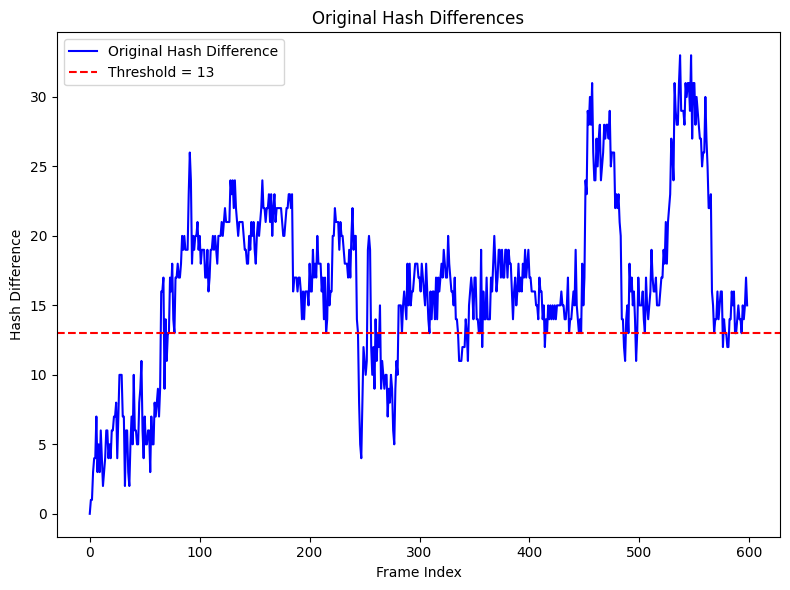

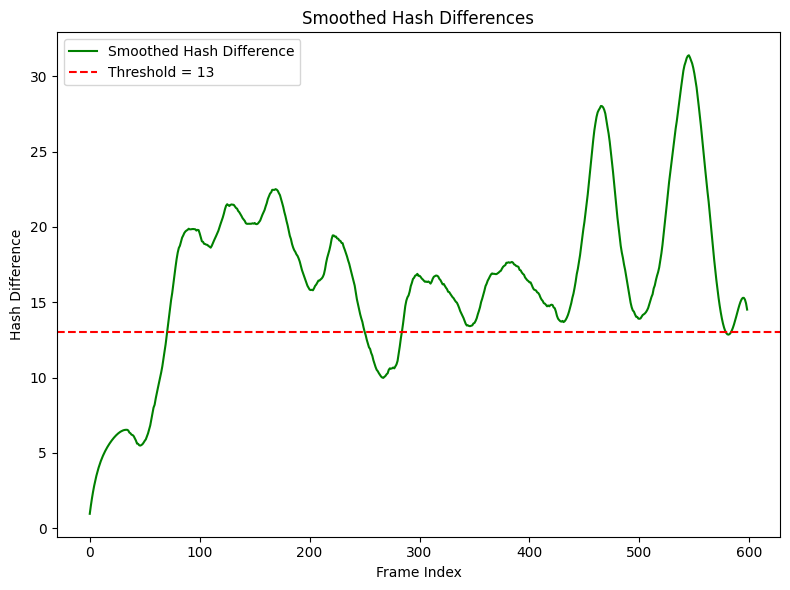

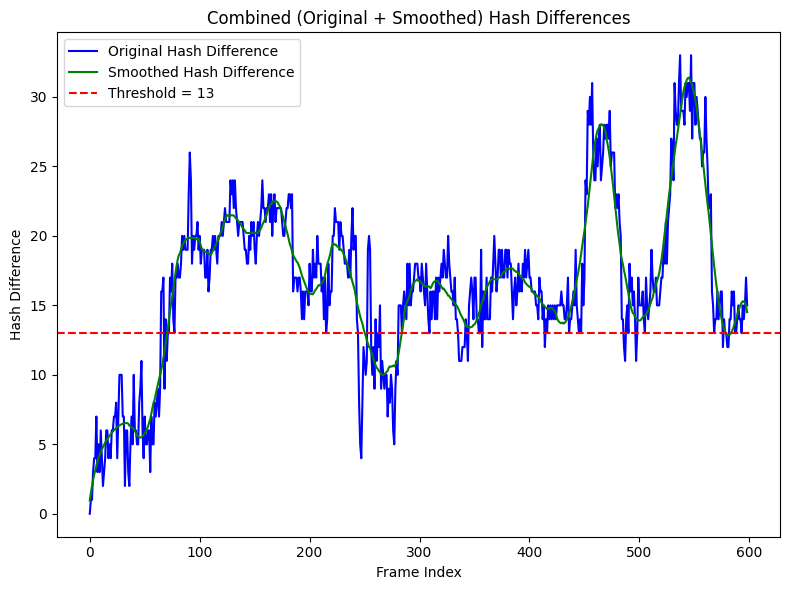

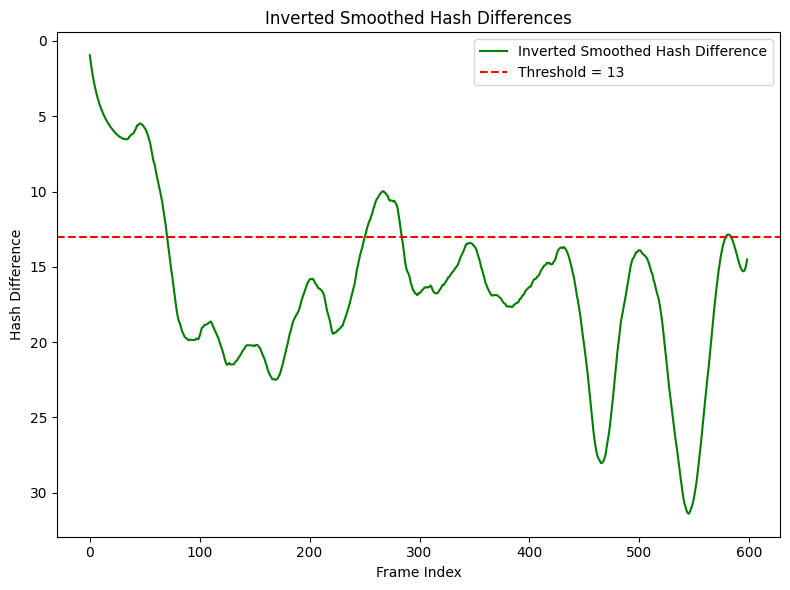

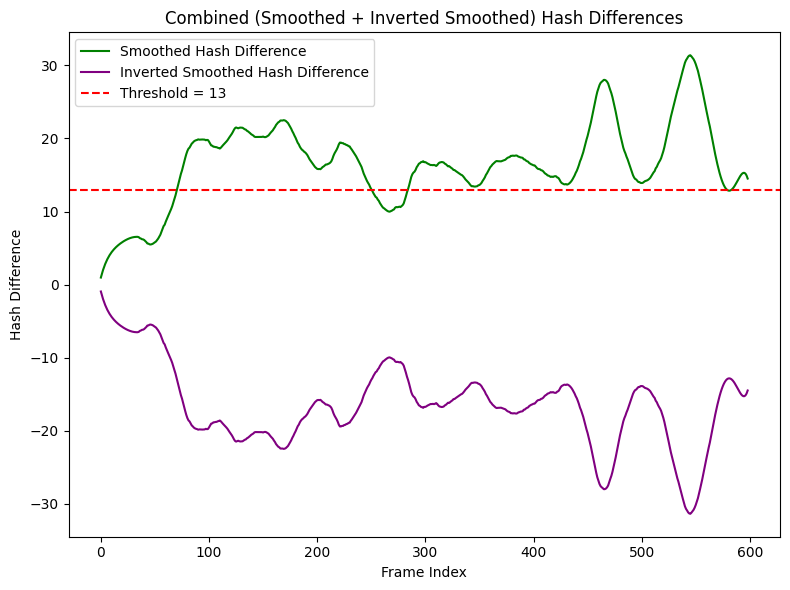

In [16]:
# Function to calculate hash differences and plot various graphs
def calculate_and_plot_hash_diff_from_frames(frame_dir, threshold_value, hash_size=12, window_length=69, polyorder=5):
    # Get all the frame file names from the directory
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.jpg') or f.endswith('.png')])

    if not frame_files:
        print("No frames found in the directory.")
        return

    # Load the first frame as the anchor frame
    anchor_frame_path = os.path.join(frame_dir, frame_files[0])
    anchor_frame = cv2.imread(anchor_frame_path)

    if anchor_frame is None:
        print(f"Error: Unable to read the anchor frame: {anchor_frame_path}")
        return

    # Calculate the dhash of the anchor frame
    anchor_hash = calculate_dhash(anchor_frame, hash_size)

    frame_idx = 0
    hash_differences = []  # To store the hash differences for plotting

    # Loop through the remaining frames in the directory
    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            print(f"Error: Unable to read the frame: {frame_path}")
            continue

        # Calculate the dhash of the current frame
        frame_hash = calculate_dhash(frame, hash_size)

        # Calculate the difference in hash values
        hash_diff = abs(anchor_hash - frame_hash)
        hash_differences.append(hash_diff)

        frame_idx += 1

    # Apply Savitzky-Golay smoothing filter to the hash differences
    smoothed_hash_differences = savgol_filter(hash_differences, window_length, polyorder)

    # Plot 1: Original Hash Differences
    plt.figure(figsize=(8, 6))
    plt.plot(range(frame_idx), hash_differences, label="Original Hash Difference", color='blue')
    plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'Threshold = {threshold_value}')
    plt.xlabel("Frame Index")
    plt.ylabel("Hash Difference")
    plt.title("Original Hash Differences")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()
    print()
    print()
    print()
    # Plot 2: Smoothed Hash Differences
    plt.figure(figsize=(8, 6))
    plt.plot(range(frame_idx), smoothed_hash_differences, label="Smoothed Hash Difference", color='green')
    plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'Threshold = {threshold_value}')
    plt.xlabel("Frame Index")
    plt.ylabel("Hash Difference")
    plt.title("Smoothed Hash Differences")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()
    print()
    print()
    print()
    # Plot 3: Combined (Original + Smoothed)
    plt.figure(figsize=(8, 6))
    plt.plot(range(frame_idx), hash_differences, label="Original Hash Difference", color='blue')
    plt.plot(range(frame_idx), smoothed_hash_differences, label="Smoothed Hash Difference", color='green')
    plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'Threshold = {threshold_value}')
    plt.xlabel("Frame Index")
    plt.ylabel("Hash Difference")
    plt.title("Combined (Original + Smoothed) Hash Differences")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()
    print()
    print()
    print()
    # Plot 4: Inverted Smoothed Hash Differences
    plt.figure(figsize=(8, 6))
    plt.plot(range(frame_idx), smoothed_hash_differences, label="Inverted Smoothed Hash Difference", color='green')
    plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'Threshold = {threshold_value}')
    plt.gca().invert_yaxis()  # Invert the Y-axis
    plt.xlabel("Frame Index")
    plt.ylabel("Hash Difference")
    plt.title("Inverted Smoothed Hash Differences")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()
    print()
    print()
    print()
    # Plot 5: Combined (Smoothed + Inverted Smoothed)
    plt.figure(figsize=(8, 6))
    plt.plot(range(frame_idx), smoothed_hash_differences, label="Smoothed Hash Difference", color='green')
    plt.plot(range(frame_idx), -smoothed_hash_differences, label="Inverted Smoothed Hash Difference", color='purple')  # Negative for inversion
    plt.axhline(y=threshold_value, color='red', linestyle='--', label=f'Threshold = {threshold_value}')
    plt.xlabel("Frame Index")
    plt.ylabel("Hash Difference")
    plt.title("Combined (Smoothed + Inverted Smoothed) Hash Differences")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage
frame_dir = "/content/Masked_Face_Eye_Detection_Mediapipe"  # Replace with the actual directory containing the frames
threshold_value = threshold_val  # Replace this with your actual threshold value
calculate_and_plot_hash_diff_from_frames(frame_dir, threshold_value, hash_size=12)


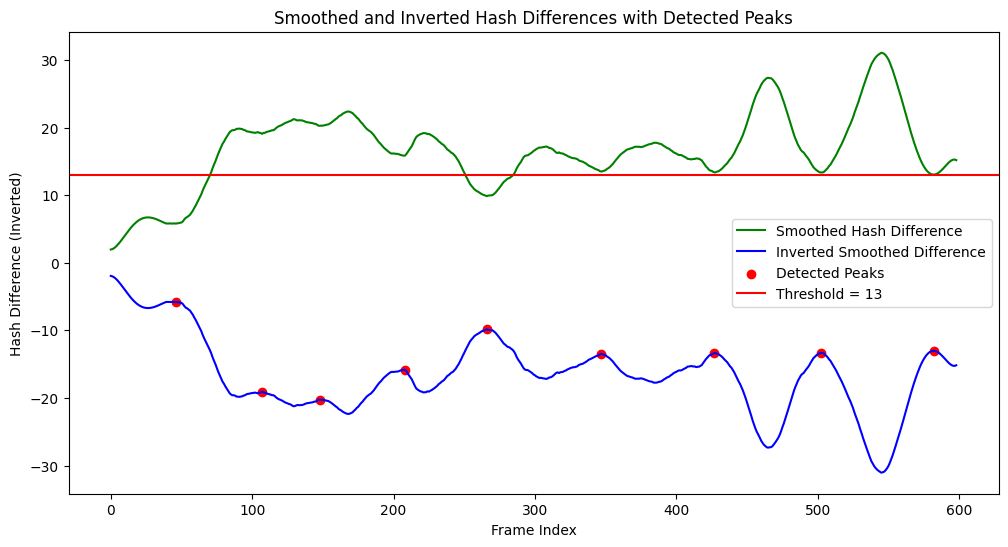

In [17]:

# Updated function to include inversion and peak detection
def calculate_and_plot_hash_diff_with_peaks(frame_dir, threshold_value, hash_size=12, window_length=79, polyorder=5):
    # Get all the frame file names from the directory
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.jpg') or f.endswith('.png')])

    if not frame_files:
        print("No frames found in the directory.")
        return

    # Load the first frame as the anchor frame
    anchor_frame_path = os.path.join(frame_dir, frame_files[0])
    anchor_frame = cv2.imread(anchor_frame_path)

    if anchor_frame is None:
        print(f"Error: Unable to read the anchor frame: {anchor_frame_path}")
        return

    # Calculate the dhash of the anchor frame
    anchor_hash = calculate_dhash(anchor_frame, hash_size)

    frame_idx = 0
    hash_differences = []  # To store the hash differences for plotting

    # Loop through the remaining frames in the directory
    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            print(f"Error: Unable to read the frame: {frame_path}")
            continue

        # Calculate the dhash of the current frame
        frame_hash = calculate_dhash(frame, hash_size)

        # Calculate the difference in hash values
        hash_diff = abs(anchor_hash - frame_hash)
        hash_differences.append(hash_diff)

        frame_idx += 1

    # Apply Savitzky-Golay smoothing filter to the hash differences
    smoothed_hash_differences = savgol_filter(hash_differences, window_length, polyorder)

    # Invert the smoothed hash differences
    inverted_smoothed = -smoothed_hash_differences

    # Find peaks in the inverted graph
    peaks, _ = find_peaks(inverted_smoothed, height=None, distance=5, prominence=0.5)

    # Plotting the smoothed hash differences over frames
    plt.figure(figsize=(12, 6))

    plt.plot(range(frame_idx), smoothed_hash_differences, label="Smoothed Hash Difference", color='green')
    plt.plot(range(frame_idx), inverted_smoothed, label="Inverted Smoothed Difference", color='blue')

    # Highlight the detected peaks
    plt.scatter(peaks, inverted_smoothed[peaks], color='red', label='Detected Peaks')

    # Add a horizontal line at the threshold value
    plt.axhline(y=threshold_value, color='r', label=f'Threshold = {threshold_value}')

    plt.xlabel("Frame Index")
    plt.ylabel("Hash Difference (Inverted)")
    plt.title(f"Smoothed and Inverted Hash Differences with Detected Peaks")
    plt.legend()
    plt.show()

frame_dir = "/content/Masked_Face_Eye_Detection_Mediapipe"  # Replace with the actual directory containing the frames
threshold_value = threshold_val  # Replace this with your actual threshold value
calculate_and_plot_hash_diff_with_peaks(frame_dir, threshold_value,hash_size=12)

[46, 110, 152, 203, 267, 310, 346, 431, 500, 581]


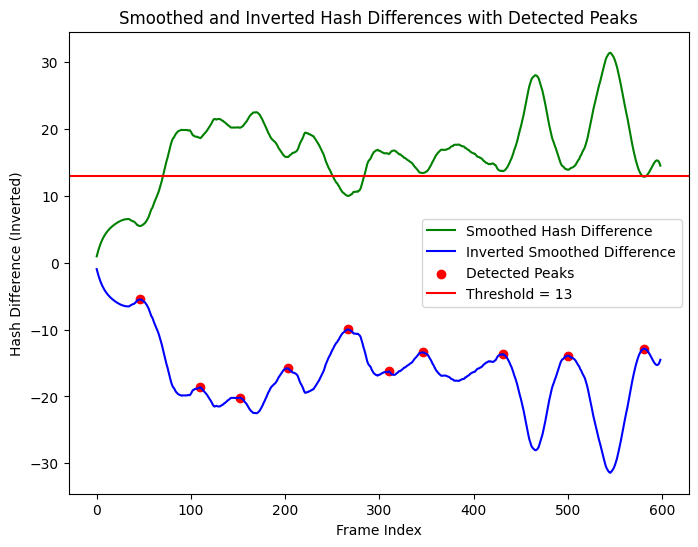

Frames where dhash difference is greater than threshold (13):
frame_0065.jpg
frame_0066.jpg
frame_0067.jpg
frame_0069.jpg
frame_0073.jpg
frame_0074.jpg
frame_0075.jpg
frame_0076.jpg
frame_0078.jpg
frame_0079.jpg
frame_0080.jpg
frame_0081.jpg
frame_0082.jpg
frame_0083.jpg
frame_0084.jpg
frame_0085.jpg
frame_0086.jpg
frame_0087.jpg
frame_0088.jpg
frame_0089.jpg
frame_0090.jpg
frame_0091.jpg
frame_0092.jpg
frame_0093.jpg
frame_0094.jpg
frame_0095.jpg
frame_0096.jpg
frame_0097.jpg
frame_0098.jpg
frame_0099.jpg
frame_0100.jpg
frame_0101.jpg
frame_0102.jpg
frame_0103.jpg
frame_0104.jpg
frame_0105.jpg
frame_0106.jpg
frame_0107.jpg
frame_0108.jpg
frame_0109.jpg
frame_0110.jpg
frame_0111.jpg
frame_0112.jpg
frame_0113.jpg
frame_0114.jpg
frame_0115.jpg
frame_0116.jpg
frame_0117.jpg
frame_0118.jpg
frame_0119.jpg
frame_0120.jpg
frame_0121.jpg
frame_0122.jpg
frame_0123.jpg
frame_0124.jpg
frame_0125.jpg
frame_0126.jpg
frame_0127.jpg
frame_0128.jpg
frame_0129.jpg
frame_0130.jpg
frame_0131.jpg
frame_01

In [18]:


# # Function to calculate the difference hash (dhash)
# def calculate_dhash(frame, hash_size=12):
#     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#     resized = cv2.resize(gray, (hash_size + 1, hash_size))
#     diff = resized[:, 1:] > resized[:, :-1]
#     dhash_value = imagehash.hex_to_hash("".join(['1' if b else '0' for b in diff.flatten()]))
#     return dhash_value


# Updated function to find frames with dhash difference greater than threshold
def calculate_and_filter_frames_above_threshold(frame_dir, threshold_value, hash_size=12, window_length=69, polyorder=5):
    # Get all the frame file names from the directory
    frame_files = sorted([f for f in os.listdir(frame_dir) if f.endswith('.jpg') or f.endswith('.png')])

    if not frame_files:
        print("No frames found in the directory.")
        return

    # Load the first frame as the initial anchor frame
    anchor_frame_path = os.path.join(frame_dir, frame_files[0])
    anchor_frame = cv2.imread(anchor_frame_path)

    if anchor_frame is None:
        print(f"Error: Unable to read the anchor frame: {anchor_frame_path}")
        return

    # Calculate the dhash of the initial anchor frame
    anchor_hash = calculate_dhash(anchor_frame, hash_size)

    frame_idx = 0
    hash_differences = []  # To store the hash differences for plotting
    peak_indices = []  # To store the indices of detected peaks
    peak_frames = []  # To store the frames corresponding to the detected peaks
    frames_above_threshold = []  # To store frames where dhash diff > threshold

    # Loop through the frames in the directory
    for frame_file in frame_files:
        frame_path = os.path.join(frame_dir, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            print(f"Error: Unable to read the frame: {frame_path}")
            continue

        # Calculate the dhash of the current frame
        frame_hash = calculate_dhash(frame, hash_size)

        # Calculate the difference in hash values
        hash_diff = abs(anchor_hash - frame_hash)
        hash_differences.append(hash_diff)

        # Check if the hash difference is greater than the threshold
        if hash_diff > threshold_value:
            frames_above_threshold.append(frame_file)

        frame_idx += 1

    # Apply Savitzky-Golay smoothing filter to the hash differences
    smoothed_hash_differences = savgol_filter(hash_differences, window_length, polyorder)

    # Invert the smoothed hash differences for peak detection
    inverted_smoothed = -smoothed_hash_differences

    # Find peaks in the inverted smoothed hash differences
    peaks, _ = find_peaks(inverted_smoothed, height=None, distance=5, prominence=0.5)

    # Now, treat the peak points as anchor frames for subsequent frames
    # Initial anchor frame is the first frame, then update whenever a new peak is detected
    anchor_frame_idx = 0
    for peak in peaks:
        # Update the anchor frame hash whenever a new peak is found
        peak_indices.append(peak)
        peak_frames.append(frame_files[peak])

        # Reset the anchor frame based on the current peak
        anchor_frame_path = os.path.join(frame_dir, frame_files[peak])
        anchor_frame = cv2.imread(anchor_frame_path)
        anchor_hash = calculate_dhash(anchor_frame, hash_size)

        # Calculate dhash differences for frames after the peak until the next peak is encountered
        for i in range(anchor_frame_idx + 1, peak):
            frame_path = os.path.join(frame_dir, frame_files[i])
            frame = cv2.imread(frame_path)

            if frame is None:
                print(f"Error: Unable to read the frame: {frame_path}")
                continue

            frame_hash = calculate_dhash(frame, hash_size)
            hash_diff = abs(anchor_hash - frame_hash)
            hash_differences.append(hash_diff)


        # Update the anchor frame index to the current peak
        anchor_frame_idx = peak

    # Plotting the smoothed hash differences and detected peaks
    plt.figure(figsize=(8, 6))
    plt.plot(range(frame_idx), smoothed_hash_differences, label="Smoothed Hash Difference", color='green')
    plt.plot(range(frame_idx), inverted_smoothed, label="Inverted Smoothed Difference", color='blue')

    # Highlight the detected peaks
    plt.scatter(peak_indices, inverted_smoothed[peak_indices], color='red', label='Detected Peaks')
    print(peak_indices)
    # Add a horizontal line at the threshold value
    plt.axhline(y=threshold_value, color='r', label=f'Threshold = {threshold_value}')

    plt.xlabel("Frame Index")
    plt.ylabel("Hash Difference (Inverted)")
    plt.title(f"Smoothed and Inverted Hash Differences with Detected Peaks")
    plt.legend()
    plt.show()

    # Return the frames where the dhash difference is greater than the threshold
    return frames_above_threshold, hash_differences

# Example usage
frame_dir = "/content/Masked_Face_Eye_Detection_Mediapipe"  # Replace with the actual directory containing the frames
threshold_value = threshold_val  # Replace this with your actual threshold value
frames_above_threshold, hash_differences = calculate_and_filter_frames_above_threshold(frame_dir, threshold_value, hash_size=12)

# Output the frames where the dhash difference is above the threshold
print(f"Frames where dhash difference is greater than threshold ({threshold_value}):")
for frame in frames_above_threshold:
    print(frame)


TP: 301, TN: 135, FP: 156, FN: 7
Accuracy: 72.79%
Precision: 65.86%
Recall (Sensitivity): 97.73%
Specificity (True Negative Rate): 46.39%
False Positive Rate (FPR): 53.61%
False Negative Rate (FNR): 2.27%
False Discovery Rate (FDR): 34.14%
F1 Score: 0.79
Matthews Correlation Coefficient (MCC): 0.52


<ipython-input-20-0394e17871a8>:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')


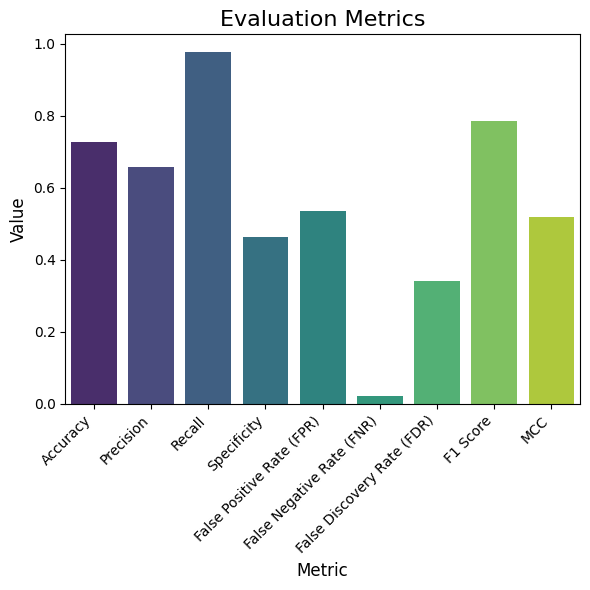

In [20]:
# Load the Excel file
file_path = '/content/Niharika - actual predicted values.xlsx'
data = pd.read_excel(file_path)

# Calculate TP, TN, FP, FN
tp = sum((data['Predicted'] == 1) & (data['Actual'] == 1))
tn = sum((data['Predicted'] == 0) & (data['Actual'] == 0))
fp = sum((data['Predicted'] == 1) & (data['Actual'] == 0))
fn = sum((data['Predicted'] == 0) & (data['Actual'] == 1))

# Total predictions
total_predictions = tp + tn + fp + fn

# Accuracy
accuracy = (tp + tn) / total_predictions

# Precision
precision = tp / (tp + fp) if (tp + fp) > 0 else 0

# Recall (Sensitivity)
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

# Specificity (True Negative Rate)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# False Positive Rate (FPR)
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

# False Negative Rate (FNR)
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

# False Discovery Rate (FDR)
fdr = fp / (fp + tp) if (fp + tp) > 0 else 0

# F1 Score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Matthews Correlation Coefficient (MCC)
mcc_numerator = (tp * tn) - (fp * fn)
mcc_denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0

# Print results
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall (Sensitivity): {recall:.2%}")
print(f"Specificity (True Negative Rate): {specificity:.2%}")
print(f"False Positive Rate (FPR): {fpr:.2%}")
print(f"False Negative Rate (FNR): {fnr:.2%}")
print(f"False Discovery Rate (FDR): {fdr:.2%}")
print(f"F1 Score: {f1_score:.2f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.2f}")

# Store the metrics in a dictionary
metrics = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "Specificity": specificity,
    "False Positive Rate (FPR)": fpr,
    "False Negative Rate (FNR)": fnr,
    "False Discovery Rate (FDR)": fdr,
    "F1 Score": f1_score,
    "MCC": mcc
}

# Create a DataFrame for plotting
metrics_df = pd.DataFrame(list(metrics.items()), columns=['Metric', 'Value'])

# Set the plot size
plt.figure(figsize=(6, 6))

# Plotting the bar chart
sns.barplot(x='Metric', y='Value', data=metrics_df, palette='viridis')

# Adding title and labels
plt.title('Evaluation Metrics', fontsize=16)
plt.ylabel('Value', fontsize=12)
plt.xlabel('Metric', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Display the plot
plt.tight_layout()
plt.show()